In [0]:
#################################
#   Kaggle ASHREA COMPEITION
#
#   COURSE: DEEP LEARNING
#
#
#   Author: Ilyes Hamrouni - II3 ISID
#
#
#   Description: Predicting Building consumption energy with deep learning model
#
#
#################################


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Imports**


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle 


# deep learning model
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import datetime
import gc
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# **Import Data**



1.   Import train.csv, weather_train.csv and building_metadata.csv
2.   Glimpse at the data shape



In [3]:
# veryfing existence of data
root = '/content/drive/My Drive/ashrae-energy-prediction/'
import os
for dirname, _, filenames in os.walk(root):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/ashrae-energy-prediction/building_metadata.csv
/content/drive/My Drive/ashrae-energy-prediction/sample_submission.csv
/content/drive/My Drive/ashrae-energy-prediction/weather_test.csv
/content/drive/My Drive/ashrae-energy-prediction/weather_train.csv
/content/drive/My Drive/ashrae-energy-prediction/train.csv
/content/drive/My Drive/ashrae-energy-prediction/test.csv


In [4]:
# importing files
%%time

train_df = pd.read_csv(root + 'train.csv')
# train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_df = pd.read_csv(root + 'weather_train.csv')
building_df = pd.read_csv(root + 'building_metadata.csv')

CPU times: user 7.51 s, sys: 1.39 s, total: 8.9 s
Wall time: 14.1 s


**Train** **Data**

In [5]:
print("Train shape: ", train_df.shape)
train_df.head()

Train shape:  (20216100, 4)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


***Weather Data***

In [6]:
print("Weather shape: ", weather_df.shape)
weather_df.head()

Weather shape:  (139773, 9)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


**Building Meta Data**

In [7]:
print("Building shape: ", building_df.shape)
building_df.head()

Building shape:  (1449, 6)


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


# **Exploration**



**General statics**





In [8]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [9]:
weather_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [10]:
building_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


**Missing Values**

In [11]:
# Train missing values

total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_df_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_df_data.head(4)

,Total,Percent
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


In [12]:
# Weather missing values

total = weather_df.isnull().sum().sort_values(ascending = False)
percent = (weather_df.isnull().sum()/weather_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_data.head(9)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


In [13]:
# Building metadata missing values

total = building_df.isnull().sum().sort_values(ascending = False)
percent = (building_df.isnull().sum()/building_df.isnull().count()*100).sort_values(ascending = False)
missing_building_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


# **Visulization**

Target : meter_reading

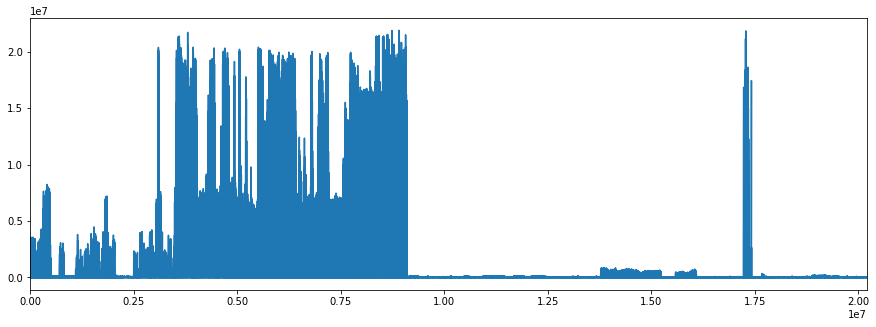

In [14]:
# TARGET   meter_reading

plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

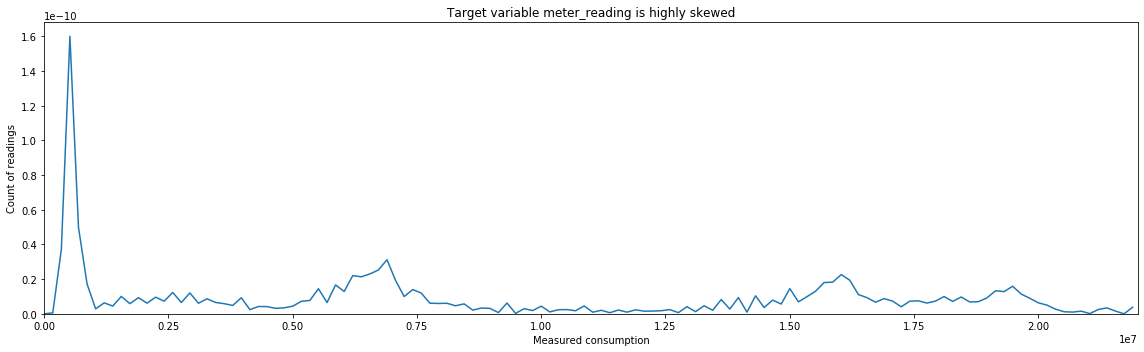

In [15]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

Buildings 

We have 1449 unique buildings and 16 sites of buildings.
The number of buildings per site range from 5 to 274.


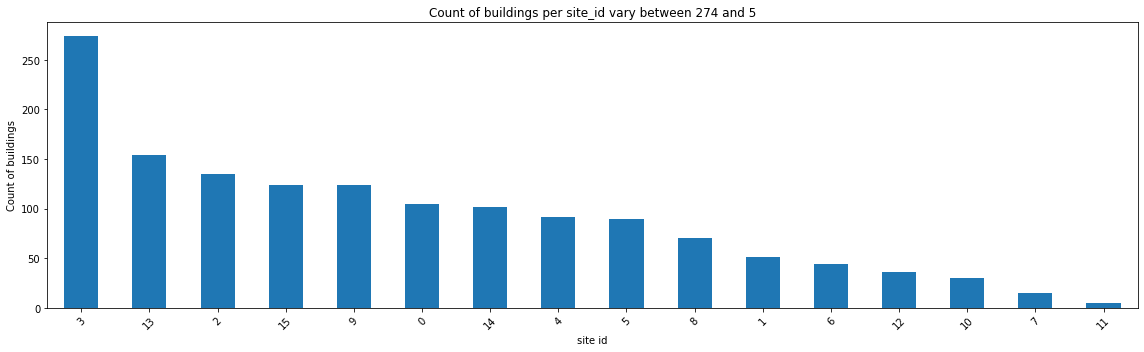

In [16]:
print(f"We have {building_df.building_id.nunique()} unique buildings and {building_df.site_id.nunique()} sites of buildings.")
sites_df = pd.DataFrame(building_df.site_id.value_counts())
sites_df.sort_values("site_id", inplace=True, ascending=False)
sites_ordered_index = sites_df.index
print(f"The number of buildings per site range from {sites_df.site_id.min()} to {sites_df.site_id.max()}.")

plt.figure(figsize=(16,5))
sites_df.site_id.plot(kind="bar")
plt.title("Count of buildings per site_id vary between 274 and 5")
plt.ylabel("Count of buildings")
plt.xlabel("site id")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Weather

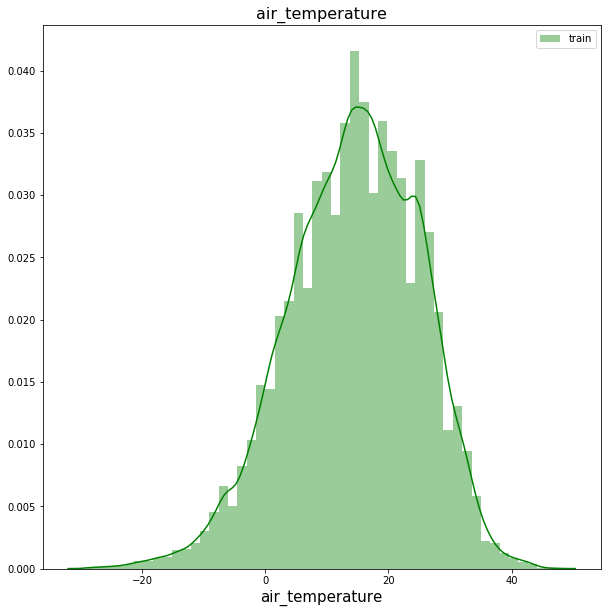

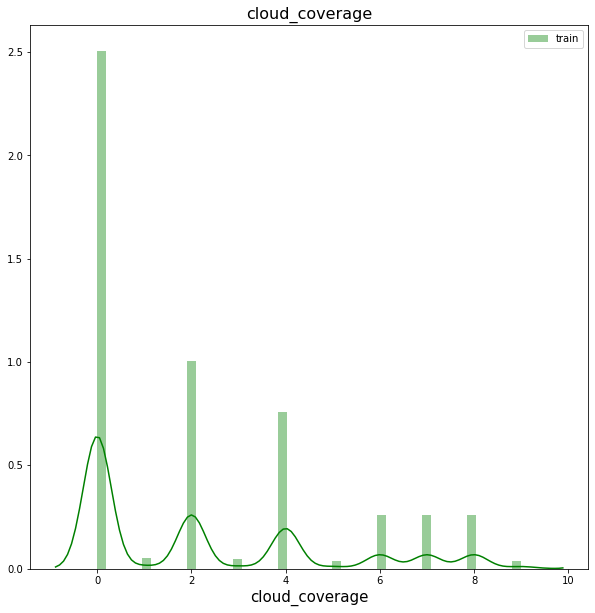

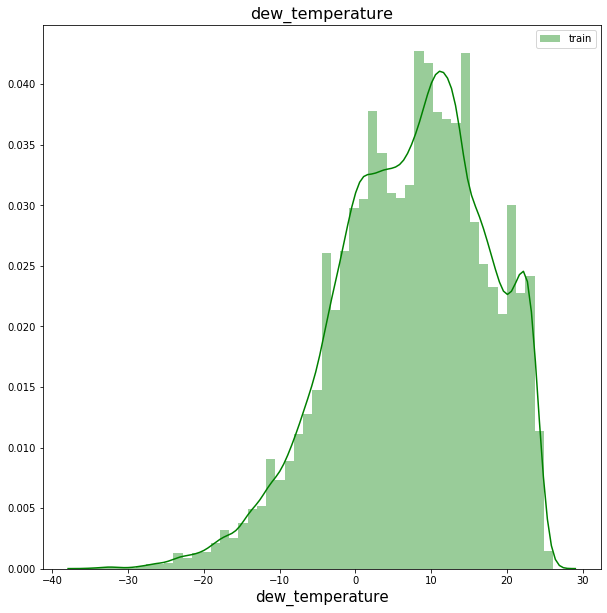

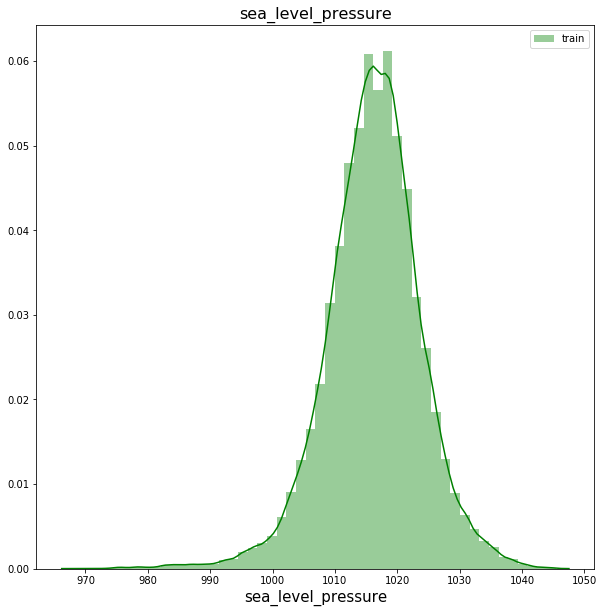

In [17]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train'])
    plt.show()

plot_dist_col('air_temperature')
plot_dist_col('cloud_coverage')
plot_dist_col('dew_temperature')
plot_dist_col('sea_level_pressure')


**Feature Correlation**

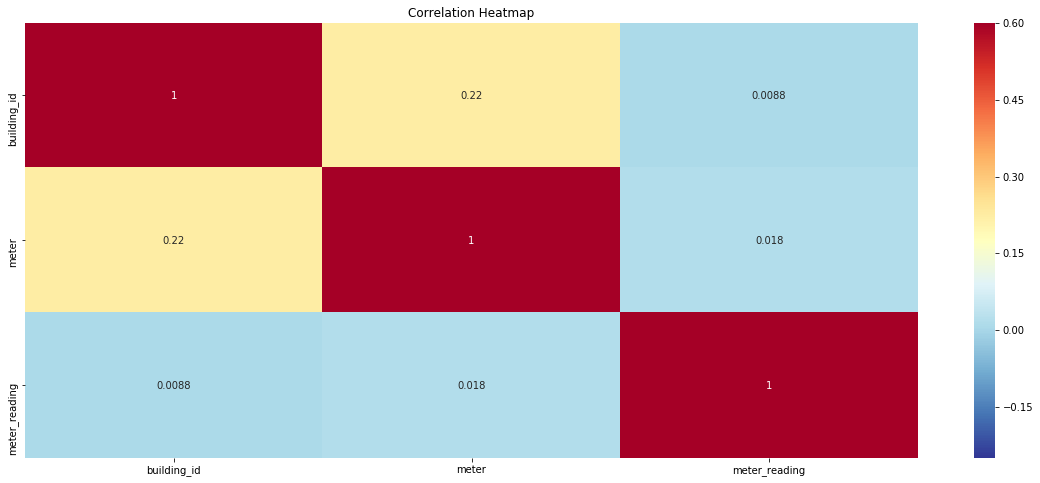

In [18]:
# Train correlation

plt.figure(figsize = (20, 8))
corrs = train_df.corr()
# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

**Time series analysis**

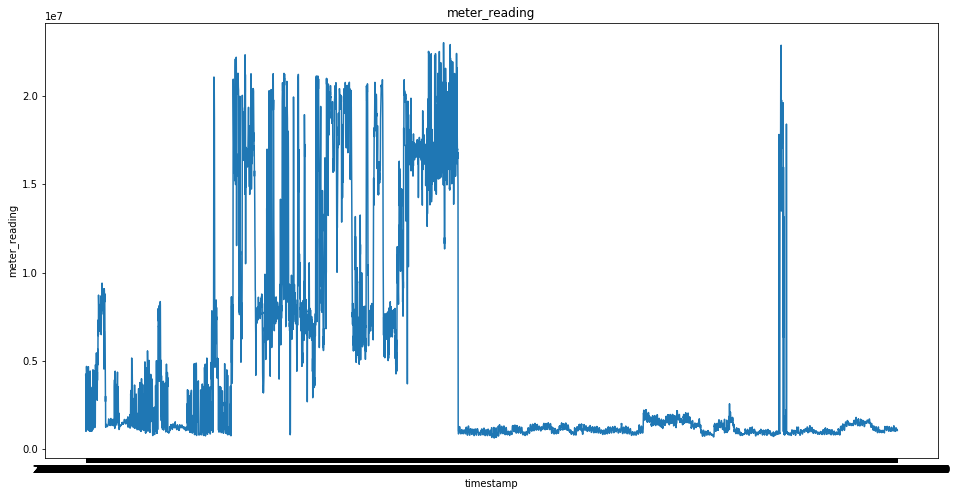

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

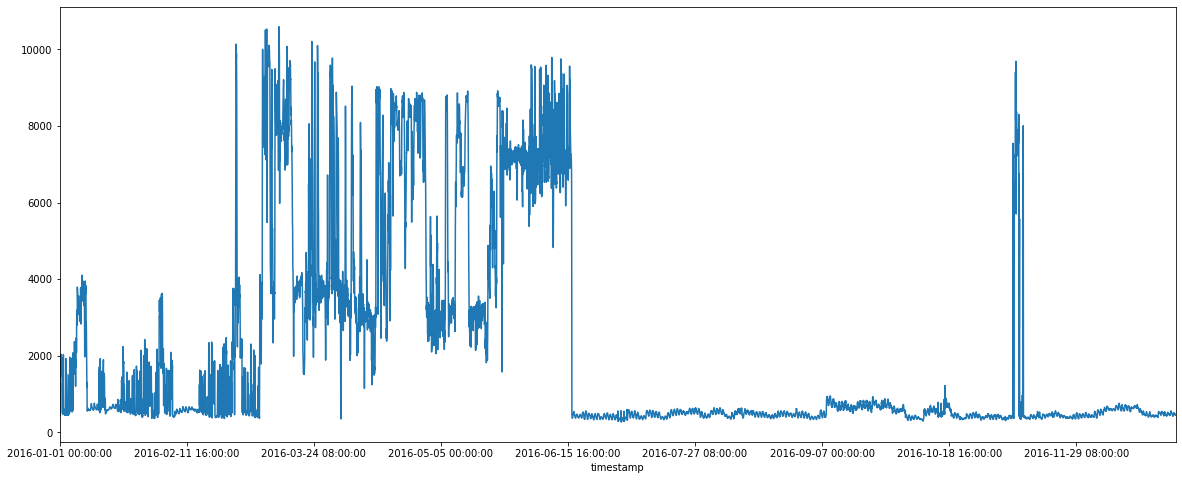

In [20]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

# **Data Preparation**



*   Removing Outliers
*   Replace Missing Values In Weather
*   Reduce Memory usage
*   Merge Data
*   Feature engineering (Encoding categories, droping unused columns


**Removing Outliers**

In [0]:
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

**Replace Missing Values In Weather**

In [0]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [0]:
weather_df = fill_weather_dataset(weather_df)

Reduce Memory usage

In [0]:

# THIS FUNCTION IS USED ACROSS THE COMPETITION TO REDUCE MEMOERY

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [25]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.5%


**Merge Data**

In [26]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

0

**Feature Engineering**

In [0]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [0]:
train_df = features_engineering(train_df)

In [29]:
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)
del train_df
gc.collect()

0

# **Training**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Dropout,Embedding, BatchNormalization
from tensorflow.keras import Sequential
from keras import backend as K



def Model():
  model = Sequential()
  model.add(Dense(512,activation='relu',input_shape=(11,)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2),)
  model.add(Dense(128,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1),)
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1),)
  model.add(Dense(32,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1),)
  model.add(Dense(16,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1),)
  model.add(Dense(1,activation='relu'))
  model.compile(loss='mse', optimizer='adam', metrics=[root_mean_squared_error])
  return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [32]:
model = Model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [35]:
model.fit(X_train,y_train,epochs=10,batch_size=8192,validation_data=(X_test,y_test),verbose=1,)

Train on 15881937 samples, validate on 3970485 samples
Epoch 1/10
15881937/15881937 [==============================] - 598s 38us/sample - loss: 2.0234 - root_mean_squared_error: 1.4223 - val_loss: 2.0647 - val_root_mean_squared_error: 1.4368
Epoch 2/10
15881937/15881937 [==============================] - 590s 37us/sample - loss: 1.9627 - root_mean_squared_error: 1.4008 - val_loss: 1.9033 - val_root_mean_squared_error: 1.3795
Epoch 3/10
15881937/15881937 [==============================] - 599s 38us/sample - loss: 1.9131 - root_mean_squared_error: 1.3830 - val_loss: 2.2106 - val_root_mean_squared_error: 1.4866
Epoch 4/10
15881937/15881937 [==============================] - 592s 37us/sample - loss: 1.8761 - root_mean_squared_error: 1.3696 - val_loss: 1.6675 - val_root_mean_squared_error: 1.2912
Epoch 5/10
15881937/15881937 [==============================] - 587s 37us/sample - loss: 1.8448 - root_mean_squared_error: 1.3581 - val_loss: 1.7063 - val_root_mean_squared_error: 1.3061
Epoch 6/10